<a href="https://colab.research.google.com/github/Denuwanhh/neural-network-notebooks/blob/main/lstm-time-series/lstm_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import joblib

In [35]:
# Load and preprocess data
file_path = "/content/sample_data/gold-price-2010-2024.csv"
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date').reset_index(drop=True)

data

,Currency,Date,Exchange Rate
0,XAU,2010-05-07,136459.7395
1,XAU,2010-05-11,136684.5647
2,XAU,2010-05-12,139577.2499
3,XAU,2010-05-13,140790.1394
4,XAU,2010-05-14,140514.5200
...,...,...,...
3073,XAU,2024-12-23,769713.5684
3074,XAU,2024-12-24,773996.5414
3075,XAU,2024-12-26,778557.7168
3076,XAU,2024-12-27,774237.5461


In [36]:
# Normalize exchange rate
exchange_rates = data['Exchange Rate'].values
scaler = MinMaxScaler(feature_range=(0, 1))
exchange_rates_scaled = scaler.fit_transform(exchange_rates.reshape(-1, 1))

exchange_rates_scaled

array([[0.00742569],
       [0.00775412],
       [0.01197981],
       ...,
       [0.94541523],
       [0.93910424],
       [0.93047611]])

In [37]:
# Create sequences
def create_sequences(data, window_size):
    sequences, labels = [], []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        labels.append(data[i + window_size])
    return np.array(sequences), np.array(labels)

window_size = 30
X, y = create_sequences(exchange_rates_scaled, window_size)

In [38]:
# Split data
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [39]:
# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [40]:
# Save scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [41]:
# Step 2: Create Time Series Sequences
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        labels.append(data[i + window_size])
    return np.array(sequences), np.array(labels)

window_size = 30
X, y = create_sequences(exchange_rates_scaled, window_size)

In [59]:
# Step 3: Split Data into Training and Testing Sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Step 4: Build the LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Predict a single value
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 30, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# Step 5: Train the Model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1.4221e-04 - val_loss: 7.7141e-04
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 1.7247e-04 - val_loss: 0.0024
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.4120e-04 - val_loss: 4.2351e-04
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.5428e-04 - val_loss: 9.3609e-04
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.4389e-04 - val_loss: 0.0015
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.3144e-04 - val_loss: 5.7892e-04
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 1.3653e-04 - val_loss: 0.0012
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.6990e-04 - val_loss: 0.0034
Epoch 9/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.7311e-04 - val_loss: 6.4568e-04
Epoch 10/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1.5413e-04 - val_loss: 4.8302e-04
Epoch 11/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 1.2900e-04 - v

In [71]:
# Step 6: Evaluate the Model
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

#Test Loss: 0.0003850847715511918

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0961e-04
Test Loss: 0.00028306085732765496


In [72]:
# Step 7: Make Predictions
predicted_prices = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [73]:
# Inverse transform predictions and test data
scaler = joblib.load('scaler.pkl')  # Load the saved scaler
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

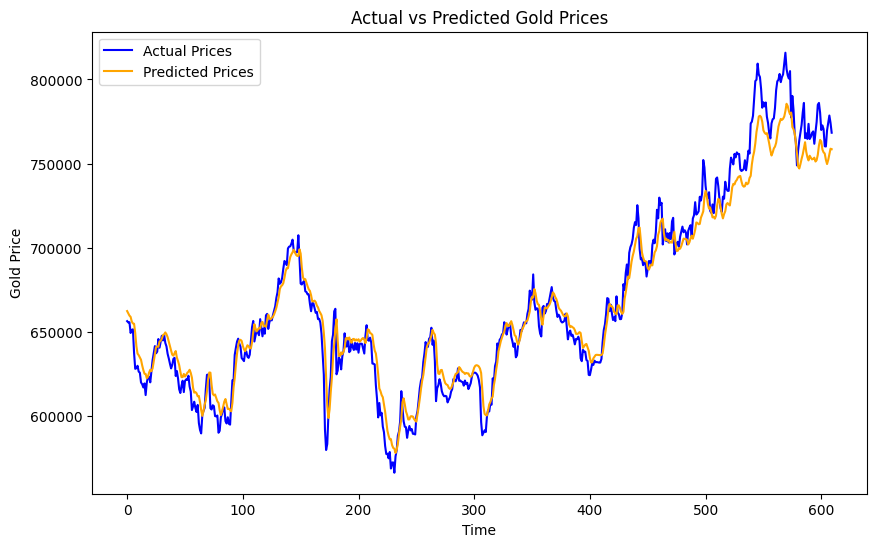

In [74]:
# Step 8: Visualize the Results
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_prices)), actual_prices, label="Actual Prices", color='blue')
plt.plot(range(len(predicted_prices)), predicted_prices, label="Predicted Prices", color='orange')
plt.title("Actual vs Predicted Gold Prices")
plt.xlabel("Time")
plt.ylabel("Gold Price")
plt.legend()
plt.show()

In [75]:
# Step 9: Save the Model (Optional)
model.save('gold_price_prediction_model.h5')
print("Model saved successfully!")

Model saved successfully!


In [80]:
from tensorflow.keras.models import load_model
import joblib
import numpy as np

# Load the saved model and scaler
model = load_model('gold_price_prediction_model.h5')
scaler = joblib.load('scaler.pkl')

# Replace with the most recent 30 days of gold prices (example values)
recent_prices = np.array([
768331.1874,
774237.5461,
778557.7168,
773996.5414,
769713.5684,
760126.4750,
760289.8220,
770447.0764,
772684.3983,
769980.1445,
780230.8665,
786061.4182,
784952.1604,
774768.0040,
768621.0530,
761764.0716,
769117.1023,
768195.2756,
765902.9140,
764582.0994,
773613.5925,
764656.9796,
767944.1483,
765114.5384,
786059.9671,
780415.8900,
772989.5096,
768426.7092,
763814.8798,
757834.7129])  # Add last 30 days' prices

recent_prices = np.flip(recent_prices)

# Preprocess the input data
recent_prices_scaled = scaler.transform(recent_prices.reshape(-1, 1))
input_data = recent_prices_scaled.reshape((1, len(recent_prices_scaled), 1))

# Predict tomorrow's price
predicted_price_scaled = model.predict(input_data)
predicted_price = scaler.inverse_transform(predicted_price_scaled)

# Print the result
print(f"Predicted Gold Price for Tomorrow: {predicted_price[0][0]}")

#            -> 755 603.1875
#768331.1874 -> 758 525.75
#774237.5461 -> 758 835.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
Predicted Gold Price for Tomorrow: 755603.1875
